In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy import optimize
from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.seasonal import STL

from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.forecasting.stl import STLForecast 

In [2]:
def custom_aic(df, cols_fitted, ytrue, yhat):
    aic = len(df) * np.log1p(((np.sum((df[ytrue] - df[yhat])**2)) / len(df))) + 2 * (len(cols_fitted) + 2)
    aicc = aic + (2 * (len(cols_fitted) + 2) * (len(cols_fitted) + 3) ) / (len(df) - len(cols_fitted) - 3)

    return aicc

O conceito básico é que, assumindo a time series de interesse $y$ possui uma relação linear com a time series $x$.

A variável de previsão $y$ é chamada também de regressando, dependente ou explicada, já $x$, a variável preditora também é chamada de regressora, independente ou explanatória ou outros nomes bonitos para ambas, em resumo, $y$ é a série alvo e $x$ são as séries independentes utilizadas para explicar $y$.

### 1.0. Linear Regression Estimators

#### 1.1. Simple Linear Regression

##### 1.1.1. Dados Artificiais

Para a regressão linear simples, temos apenas a variável dependente $y$ e uma variável independente $x$, representada por esta equação:

$y_t = \beta_1x_t + \beta_0 + e_t$

Em linhas gerais, assumindo que $x$ possui uma relação linear com a variável $y$, portanto dado que temos essas duas variáveis podemos tentar traçar uma linha linear entre ambas.

Por exemplo, o gráfico abaixo, temos um par (x, y) para cada parzinho de pontos podemos desenhar algumas retas que ligam esses pares de pontos com a equação: $y = ax + b$, isso já sabemos desde o ensino básico, então metade do caminho já esta concluído, entretanto o objetivo não é apenas um par de pontos, e sim o melhor $a$ e $b$ que ajusta esses dados levando em conta todos os pontos, então as equações para encontrar o $a$ e $b$ na regressão linear são diferentes a fim de levar em conta todos os pontos.

Em ambas as fórmulas, possuem os coeficientes do ângulo ($a$ e $\beta_1$) e da altura, ou seja, qual posição no eixo y irá ficar, representada pelo ($\beta_0$ e $b$) e antes que esqueça, existe um termo $e$ que nada mais é que uma indicação de uma flutuação estatística, em outras palavras, nem todo ponto pode cair exatamente em cima da reta pois estou levando em conta a melhor reta para $n$ pontos.

y = 1.6667 * x + -0.3333


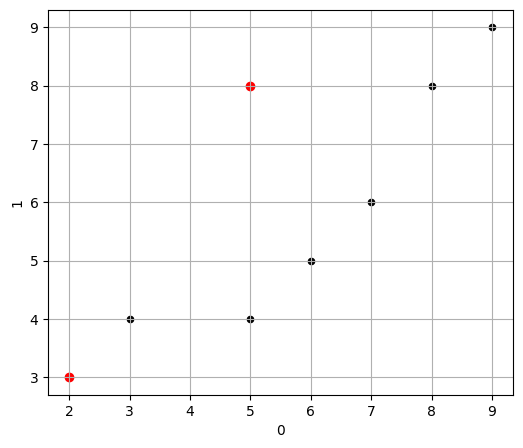

In [3]:
df = pd.DataFrame(
    [[2, 3, 6, 5, 5, 7, 9, 8],
     [3, 4, 5, 4, 8, 6, 9, 8]]
).T

x1, y1 = 2, 3
x2, y2 = 5, 8

a = (y1 - y2) / (x1 - x2)
b = y1 - (x1 * a)

eq = lambda x: a * x + b
print(f"y = {a:.4f} * x + {b:.4f}")

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k", grid=2);
ax.scatter(x=[x1, x2], y=[y1, y2], color='r');

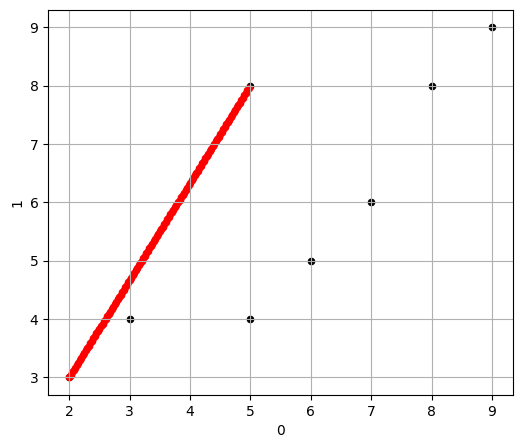

In [4]:
df2 = pd.DataFrame([[x, eq(x)] for x in np.arange(2, 5, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

Mas, como iremos levar em conta todos os pontos ?
Nesse caso iremos utilizar a regressão linear com a mesma ideia da fórmula, entretanto ajustando a mesma para levar em conta todos os pontos, ideia simples, porem é um pouco mais trabalhoso. Em resumo, são várias somatórias e multiplicações para encontrar os melhores valores de $a$ e $b$, ou $\beta_1$ e $\beta_0$.

$b = \frac{n \times \sum xy - \sum x \times \sum y}{n \times \sum x^{2} - (\sum x)^{2}}$

$a = \frac{\sum y - b \times \sum x}{n}$

Mas, na vida real, utilizamos um algorítimo a fim de minimizar a soma dos erros ao quadrado, esse algoritimo irei detalhar no capítulo 12 em deep learning para regressão linear.

In [5]:
n = len(df)

x2 = np.sum(df[0] ** 2)
xx = np.sum(df[0]) ** 2

y2 = np.sum(df[1] ** 2)
xy = np.sum(df[0] * df[1])

beta1 = (n * xy - np.sum(df[0]) * np.sum(df[1])) / (n * x2 - xx)

beta0 = (np.sum(df[1]) - beta1 * np.sum(df[0])) / n

# y = ax + b
eq = lambda x: beta1 * x + beta0

beta1, beta0

(0.768025078369906, 1.5548589341692791)

Os dados não ficam exatamente em cima da linha pois existe o termo de $e$ embutido, no livro existe uma imagem maravilhosa representado isso.

![image](https://otexts.com/fpp3/fpp_files/figure-html/SLRpop1-1.png)

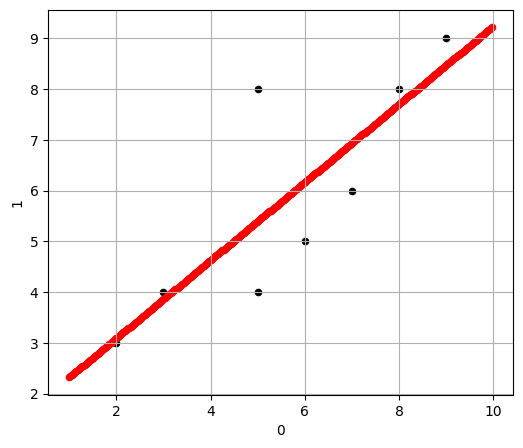

In [6]:
df2 = pd.DataFrame([[x, eq(x)] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

Se nós modificarmos os dados e incluir um outlier no dataset, claramente vai dar probleminhas pois a formula é multiplicações e somatórias, consequentemente um valor muito alto vai acarretar em somas e multiplicações altas.

In [7]:
df = pd.DataFrame(
    [[2, 3, 6, 5, 5, 7, 9, 8],
     [3, 4, 5, 4, 8, 6, 50, 80]]
).T

df

,0,1
0,2,3
1,3,4
2,6,5
3,5,4
4,5,8
5,7,6
6,9,50
7,8,80


In [8]:
n = len(df)

x2 = np.sum(df[0] ** 2)
xx = np.sum(df[0]) ** 2

y2 = np.sum(df[1] ** 2)
xy = np.sum(df[0] * df[1])

beta1 = (n * xy - np.sum(df[0]) * np.sum(df[1])) / (n * x2 - xx)

beta0 = (np.sum(df[1]) - beta1 * np.sum(df[0])) / n

# y = ax + b
eq = lambda x: beta1 * x + beta0

beta1, beta0

(8.526645768025078, -27.962382445141067)

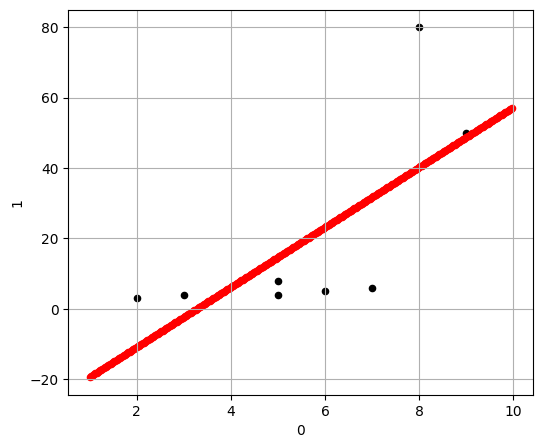

In [9]:
df2 = pd.DataFrame([[x, eq(x)] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);

Agora se quisermos prever quando que vai ser o valor dado um novo x, basta chamar a função e é possível estrapolar valores com a regressão.

In [10]:
x = 11

eq(x)

65.83072100313478

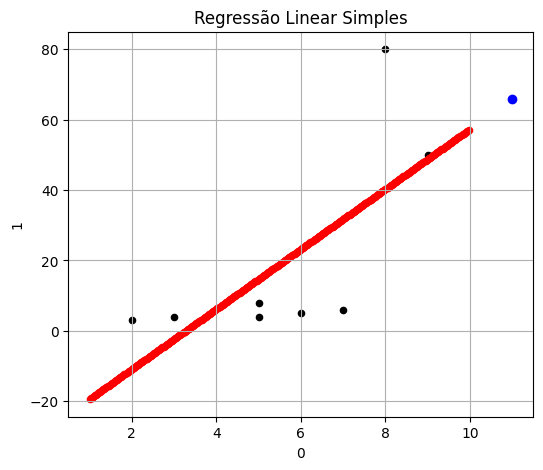

In [11]:
df2 = pd.DataFrame([[x, eq(x)] for x in np.arange(1, 10, 0.025)])

ax = df.plot(kind="scatter", x=0, y=1, figsize=(6, 5), color="k")
ax.scatter(x=x, y=eq(x), color="b")

df2.plot(kind="scatter", x=0, y=1, color="r", grid=2, ax=ax);
ax.set_title("Regressão Linear Simples");

Existem algumas assumptions a serem avaliadas sobre os resíduos quando utilizamos a regressão linear.

Primeiro, assumimos que o modelo é uma aproximação razoável da realidade, ou seja, as variáveis possuem um fenômeno linear e podem ser aproximadas por uma equação linear.

E também assumimos algumas características para os resíduos:

1. Os resíduos possuem média 0, caso contrário a previsão é enviesada.
2. Os resíduos não são correlacionados, caso contrário a previsão é ineficiente e existem mais informações nos dados que podem ser obtidas.
3. Os resíduos não são correlacionados com nenhuma das variáveis, caso contrário existem mais informações nessas variáveis que o modelo não capturou.
3. Os resíduos são normalmente distribuídos e possuem variância constante, caso contrário os intervalos de previsão podem ser imprecisos.

In [15]:
df["yhat"] = [eq(x) for x in df[0]]
df["resid"] = df[1] - df["yhat"]

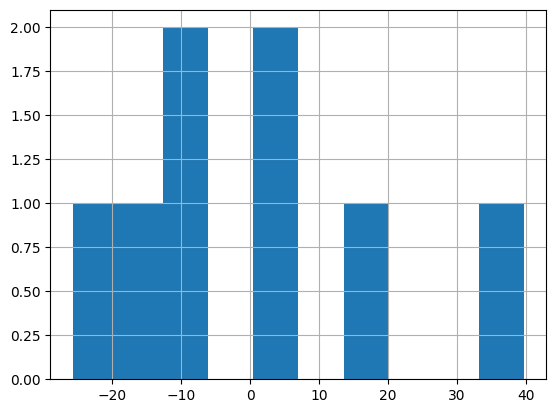

In [20]:
df["resid"].hist();

##### 1.1.2. US Changes

In [5]:
df = pd.read_csv('../data/us_change.csv', index_col=[0])
df.Quarter = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df.Quarter = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

O gráfico de scatter (citado no capítulo 2) aparentemente não mostra uma relação muito linear entre as duas variáveis, a correlação é 0.38.

In [51]:
df[["Consumption", "Income"]].corr()

,Consumption,Income
Consumption,1.000000,0.383713
Income,0.383713,1.000000


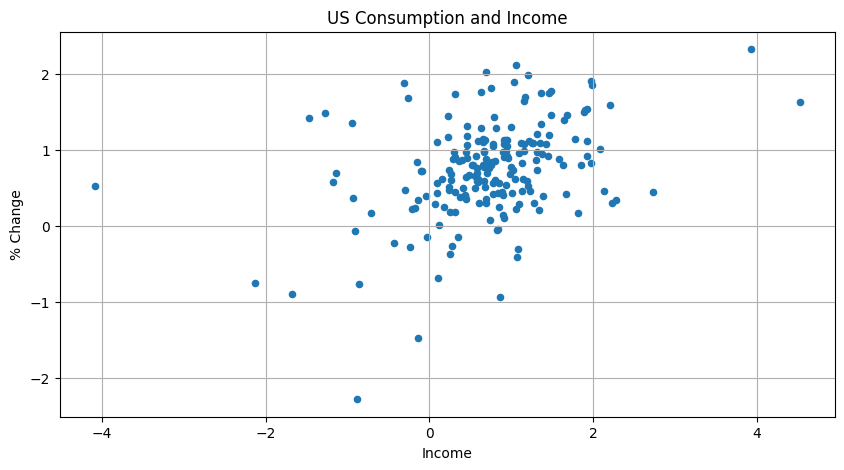

In [48]:
df.plot(
    kind='scatter', 
    x='Income', 
    y='Consumption',
    figsize=(10,5),
    ylabel='% Change',
    grid='O',
    title='US Consumption and Income'
);

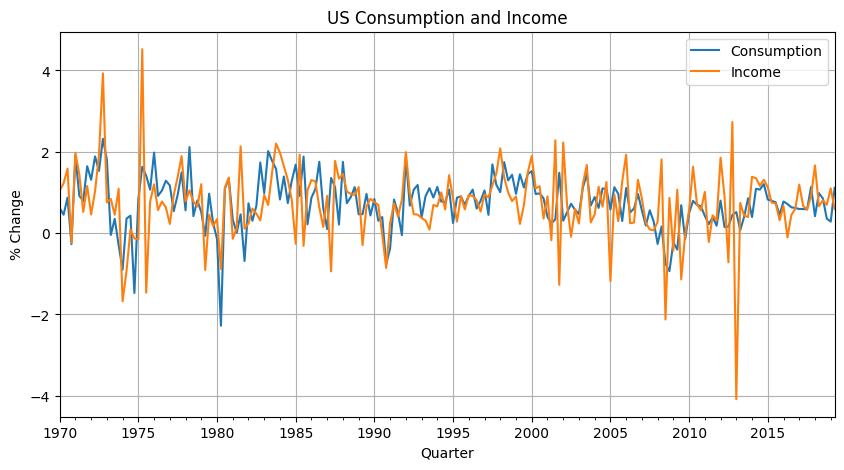

In [46]:
df.plot(
    kind='line', 
    x='Quarter', 
    y=['Consumption', 'Income'],
    figsize=(10,5),
    ylabel='% Change',
    grid='O',
    title='US Consumption and Income'
);

Para treinar uma regressão linear sem precisar escrever na mão, existe o statsmodels e outras libs que nos ajudam. Entretanto a fórmula de treinamento não é igual a fórmula que criemos antes, leva em conta a função dos mínimos quadrados a fim de encontrar os melhores betas que reduz a soma dos erros ao quadrado, e os erros nesse sentido são os resíduos da regressão, o valor real subtraído do valor previsto.

E usando o summary ele retorna algumas descrições estatísticas interessantes.

Como, na primeira linha e primeira coluna a variável dependente, modelo (OLS), método utilizado para treinamento (Least Squares), A data de treinamento, o número de observações ($n$) ou len(df), o número de graus de liberdade que é sempre $n - 1$, os graus de liberdade do modelo que nesse caso é 1 pois só existe uma variável independente e a covariância.

Já na coluna ao lado, existem algumas métricas, as importantes que o livro aborda são o R2, AIC e BIC.

Logo abaixo, na coluna "coef" está as variáveis independentes e como elas afetam o modelo, o coef diz respeito do número quando o Income é 1 e qual é o valor de Consumption quanto de incremento na variável dependente isso afeta, o Std Err diz respeito a qual o intervalo em estimar o coef levando em conta um problema linear pois é estimado vários betas durante o treinamento, o t é a estatística t e por fim o P>|t| é o p-valor, em outras palavras, indica se a variável é importante ou não para o treinamento e estimação do modelo.

In [57]:
est = sm.OLS(
    df['Consumption'],
    df['Income']
).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Consumption   R-squared (uncentered):                   0.452
Model:                            OLS   Adj. R-squared (uncentered):              0.449
Method:                 Least Squares   F-statistic:                              162.4
Date:                Sat, 16 Dec 2023   Prob (F-statistic):                    1.62e-27
Time:                        12:10:05   Log-Likelihood:                         -216.99
No. Observations:                 198   AIC:                                      436.0
Df Residuals:                     197   BIC:                                      439.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Income         0.5684      0.045     12.742      0.000       0.480       0.656
==============================================================================
Omnibus:                       14.264   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.359
Skew:                           0.238   Prob(JB):                     5.70e-08
Kurtosis:                       4.954   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Caso o Income seja 1, o consumption é 0.56.

In [61]:
print(est.predict([0, 1, 2, 3]))

[0.         0.56844113 1.13688226 1.7053234 ]


In [62]:
df['Yhat'] = est.predict(df['Income'])

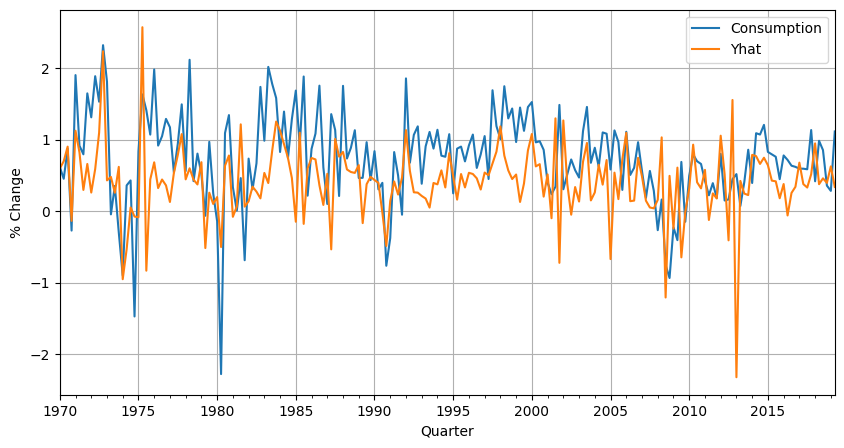

In [63]:
df.plot(
    kind='line', 
    x='Quarter', 
    y=['Consumption', 'Yhat'],
    figsize=(10,5),
    ylabel='% Change',
    grid=True
);

In [64]:
df.drop('Yhat', axis=1, inplace=True)

#### 1.2. Multiple Linear Regression

Quando se existe mais de uma variável independente para estimar a variável dependente e assumimos que essas variáveis possuem um comportamento linear podemos utilizar uma regressão linear múltipla.

A fórmula geral da regressão múltipla é:

$y_t = \beta_0 + \beta_1 x_{1,t} + \beta_2 x_{2,t} + ... + \beta_k x_{k,t} + e_t$

Onde y é a variável dependente a ser prevista (variável alvo) e $x_k$ são as $k$ features no dataset, no exemplo anterior, $k = 1$ e os coeficiêntes $\beta$ medem o efeito de cada uma das variáveis.

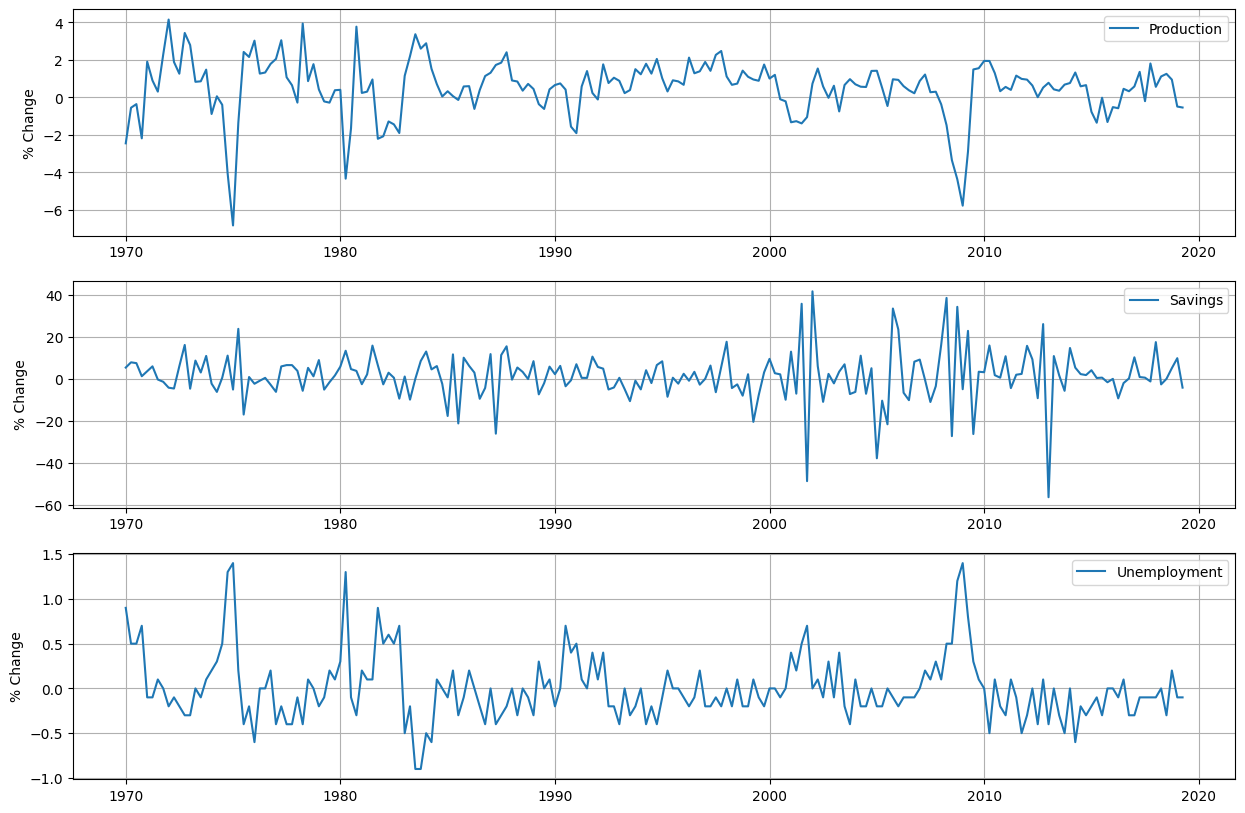

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))
for i, k in enumerate(['Production', 'Savings', 'Unemployment']):
    ax[i].plot(df['Quarter'], df[k], label=k)
    ax[i].set_ylabel('% Change')
    ax[i].grid('on')
    ax[i].legend()

##### Estimator Fit

Usando as $k=4$ variáveis para estimar a variável alvo $y$, claramente as previsões ficaram melhores.

In [7]:
est = sm.OLS(
    df['Consumption'],
    df[['Income', 'Production', 'Savings', 'Unemployment']]
).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Consumption   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              337.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):                    3.22e-86
Time:                        15:27:58   Log-Likelihood:                         -71.049
No. Observations:                 198   AIC:                                      150.1
Df Residuals:                     194   BIC:                                      163.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Income           0.9435      0.033     28.757      0.000       0.879       1.008
Production       0.0793      0.026      3.093      0.002       0.029       0.130
Savings         -0.0634      0.003    -22.089      0.000      -0.069      -0.058
Unemployment     0.0763      0.101      0.758      0.449      -0.122       0.275
==============================================================================
Omnibus:                       27.558   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.142
Skew:                           0.531   Prob(JB):                     3.96e-18
Kurtosis:                       5.930   Cond. No.                         49.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
df['Yhat'] = est.predict(df[['Income', 'Production', 'Savings', 'Unemployment']])
df['Error'] = df['Consumption'] - df['Yhat']

R2 Score: 0.7035524246067222
AIC: 150.09776326169043


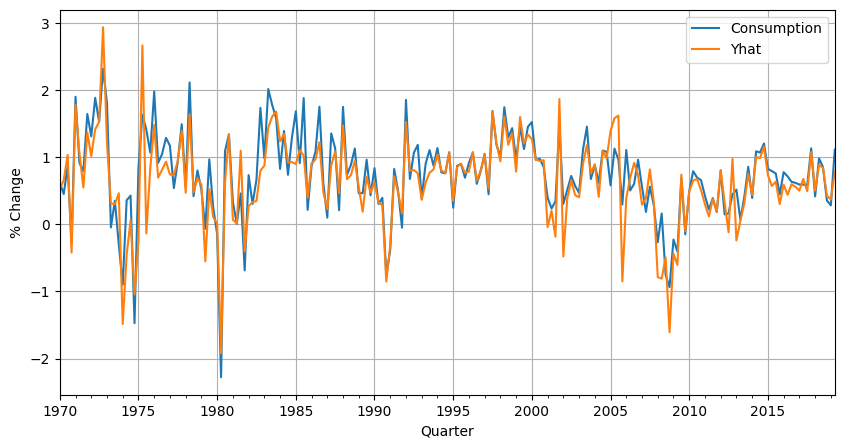

In [21]:
print(f"R2 Score: {r2_score(df['Consumption'], df['Yhat'])}")
print(f"AIC: {est.aic}")

df.plot(
    kind='line', 
    x='Quarter', 
    y=['Consumption', 'Yhat'],
    figsize=(10,5),
    ylabel='% Change',
    grid=True
);

### 2.0. Residual Analysis

A diferença do real e do previsto (yhat) é chamado de resíduos / Erro.

E existem as hipóteses e as assumptions dos mesmos citadas no começo do notebook.

A soma dos resíduos não é 0, ou seja, eu poderia ajustar as previsões utilizando a subtração em todos os valores para remover esse viés positivo igual foi citado nos capítulos anteriores.

Já a variância não é constante ao longo do tempo, se selecionarmos pedaços dos dados e analisarmos individualmente cada parte veremos que não é constante.

In [14]:
np.sum(df["Error"]), np.std(df["Error"])

(20.498840994272825, 0.3305871680733222)

In [29]:
df["Year"] = df["Quarter"].dt.year

df[["Year", "Error"]].groupby("Year").std().head()

,Error
Year,
1970,0.178345
1971,0.189382
1972,0.477744
1973,0.580736
1974,0.539642


/tmp/ipykernel_10355/981497984.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


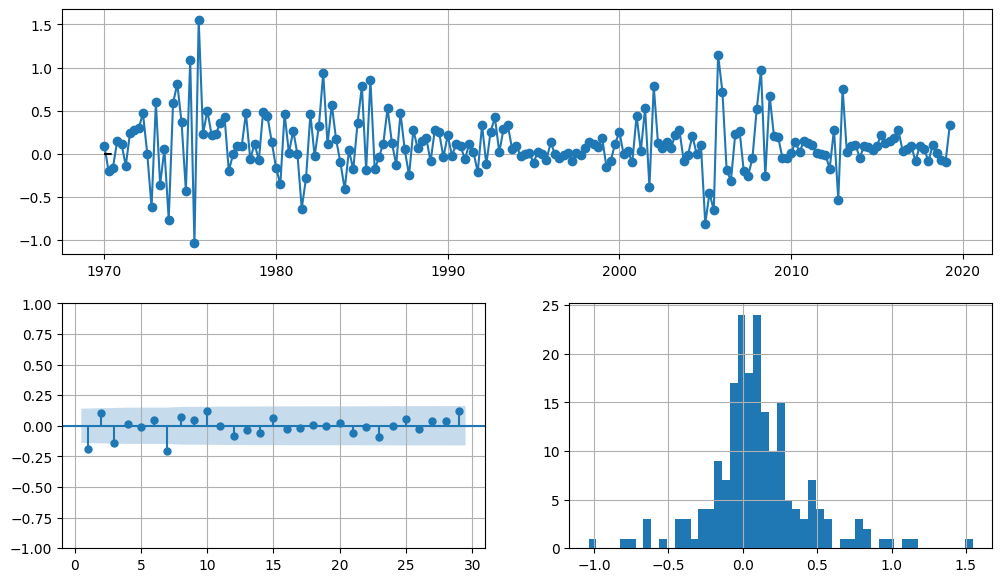

In [23]:
_, _, = plt.subplots(figsize=(12,7))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((2, 2), (1, 0))
ax2 = plt.subplot2grid((2, 2), (1, 1));

ax0.plot(df['Quarter'], df['Error'], marker='o')
ax0.hlines(0, 0, df['Error'].shape[0], color='k', linestyle='--')

plot_acf(df['Error'], ax=ax1, lags=range(1, 30), title='')

ax2.hist(df['Error'], bins=len(df) // 4)

for axi in [ax0, ax1, ax2]: axi.grid('on')

Os gráficos do erro com os valores fitados e as variáveis não apresentaram nenhum padrão sistemático como o livro cita, nesse caso essas análises estão boas.

Caso apresentasse algum padrão, seja em relação a varíavel resposta ou as independentes com o Erro, ou alguma relação não linear o modelo deveria ser ajustado de acordo com a visualização observada, por exemplo, para resolver o problema da heteroskedasticidade precisamos aplicar um Log ou algum Raiz na variável que apresenta esse problema.

É importante também plotar os resíduos com todas as variaveis do conjunto de dados e as quais não foram utilizadas no modelo, caso possível, assim conseguimos analisar se existe algum padrão sistemático, caso exista, essa variável precis aser incluida no modelo.

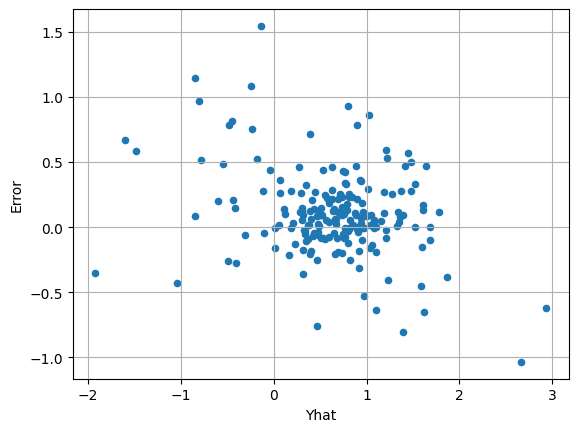

In [22]:
df[["Error", "Yhat"]].plot(
    kind="scatter", x="Yhat", y="Error", grid=2
);

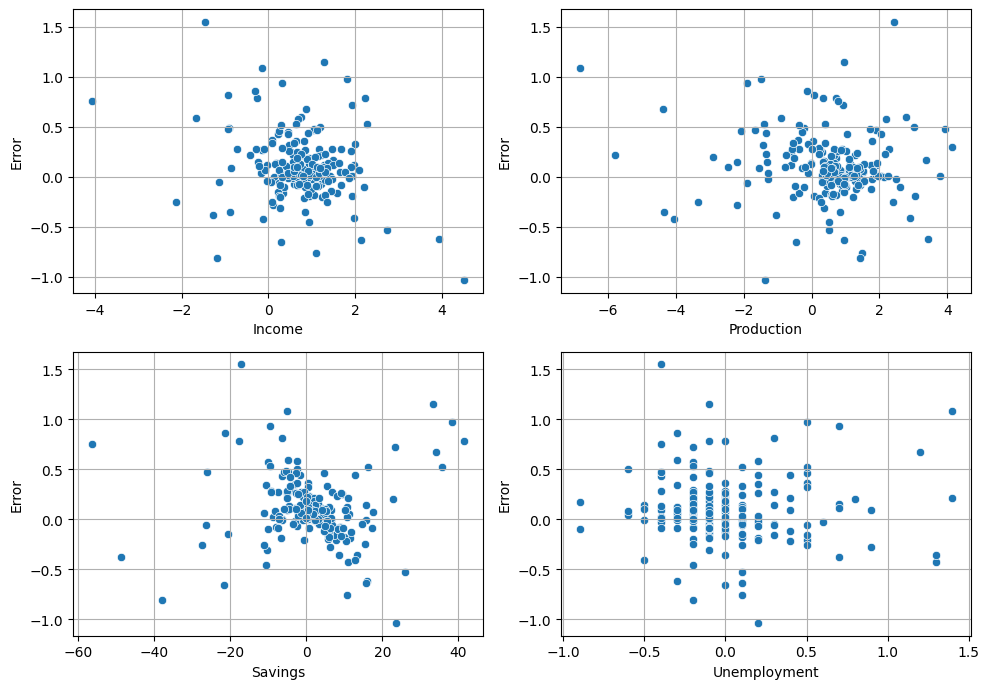

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.flatten()
for i, k in enumerate(['Income', 'Production', 'Savings', 'Unemployment']):
    sns.scatterplot(x=df[k], y=df['Error'], ax=ax[i])
    ax[i].grid(2)
    
plt.tight_layout()

Existe também a **análise do outlier** durante as primeiras etapas de um projeto de previsão na análise estatística.

O Livro aborda também a **correlação espúria**, e o exemplo é: prever o transporte aéreo na austrália utilizando a produção de arroz na Guinea.

### 3.0. Feature Engineering

Algumas vezes você pode ter várias variáveis independentes e precisa selecionar elas posteriormente, mas, há casos em que vocÊ precisa criar novas variáveis independentes.

Algumas que você pode criar e utilizar são:

1. Variáveis da Decomposição (Tendência e Sazonalidade).
2. Variáveis Dummy.
    1. Usar uma ferramenta para análiser outlier e criar uma nova variável que é a indicação ou a probabilidade da linha ser um outlier.
    2. Indicar holidays.
    3. Dia, Semana, Mês, Quarter, Ano.
    4. As **Estatísticas de Time Series**.
    5. Estações do Ano.
    6. ...
3. Variáveis de Intervenção.
    1. Variáveis externas que podem ser derivadas em análise de hipóteses.
    2. Variáveis que ajudam a explicar algum fenômeno nos dados, exemplo uma queda...
    3 ...
4. **Lags** (É bem comum usar as variáveis lags, principalmente em competições).
5. Séries de Fourier (Você pode modelar séries sinusoidal).

### 4.0. Linear Regression Feature Selection

Não podemos utilizar o p-valor ou a análise univariada para selecionar variáveis independentes mas podemos ter uma visão sobre elas pois a combinação delas podem gerar resultados interessantes.
Usamos métricas para computacionar a acurácia e o cross validation para a seleção de variáveis.

Algumas métricas são:

- Adj R2: $1 - (1 - R^2) * \frac{T - 1}{T - k - 1}$
- AIC: $T * log(\frac{\sum e^2}{T}) + 2 * (k + 1)$
- AICc: $AIC + \frac{2 * (k + 2) * (k + 3)}{T - k - 3}$
- BIC: $T * log(\frac{\sum e^2}{T}) * (k + 2) * log(T)$

No exemplo de previsão do consumo nos EUA, foi treinado 12 modelos pois existem uma combinação de 4 variáveis independentes os melhores fits estão listados abaixo, podemos fazer desta forma em fitar todos os modelos possíveis, entretanto pode ser computacionalmente custoso caso não seja feito em paralelo ou em um cluster ou ir removendo features e treinando por seleção.

In [26]:
train_cols = ['Income', 'Production', 'Savings', 'Unemployment']
combs = []

for r in range(1, len(train_cols) + 1):
    combs.extend(list(combinations(train_cols, r)))

combs = [list(comb) for comb in combs]

# All Possible combinarions
[list(l) for r in range(1, len(train_cols) + 1) for l in list(combinations(train_cols, r))]

[['Income'],
 ['Production'],
 ['Savings'],
 ['Unemployment'],
 ['Income', 'Production'],
 ['Income', 'Savings'],
 ['Income', 'Unemployment'],
 ['Production', 'Savings'],
 ['Production', 'Unemployment'],
 ['Savings', 'Unemployment'],
 ['Income', 'Production', 'Savings'],
 ['Income', 'Production', 'Unemployment'],
 ['Income', 'Savings', 'Unemployment'],
 ['Production', 'Savings', 'Unemployment'],
 ['Income', 'Production', 'Savings', 'Unemployment']]

In [27]:
df_res = pd.DataFrame()

for comb_idx in range(0, len(combs)):
    est = sm.OLS(
        df['Consumption'],
        df[combs[comb_idx]]
    ).fit()

    df['Yhat'] = est.predict(df[combs[comb_idx]])

    res = pd.DataFrame(
        {'r2': r2_score(df['Consumption'], df['Yhat']), 
        'AIC': est.aic,
        'AIC2': custom_aic(df, combs[comb_idx], 'Consumption', 'Yhat'),
        'comb_idx': comb_idx},
        index=[0]
    )

    df_res = pd.concat([df_res, res], axis=0)

df_res = df_res.sort_values(by='r2', ascending=False)

In [28]:
df_res.head()

,r2,AIC,AIC2,comb_idx
0,0.703552,150.097763,34.879972,14
0,0.702675,148.683080,32.815480,10
0,0.688936,157.627268,33.795964,12
0,0.682969,159.389420,32.115045,5
0,-0.042067,397.001753,79.999454,11


In [29]:
print(combs[12])
print(combs[5])

['Income', 'Savings', 'Unemployment']
['Income', 'Savings']


### 5.0. Non Linear Regression

Regressão não linear é outro rolê, no livro é citado a regressão de piercewise e a aplicação do Log das variáveis independentes e dependentes.

Teoricamente não podemos utilizar outros graus e tentar desenvolver uma regressão polinomial em vez de uma linear pois podemos gerar previsoes não levando em conta os dados e sim o grau do polinômio mais isso acredito que varia de problema a problema, pois podemos usar árvores de decisão e versões mais sofisticadas como Random Forest e Xgboost que são amplamente utilizadas em problemas de regressão e não são lineares.

A aplicação do Log pode ajudar a reduzir a tendência e deixar mais flat os dados para a aplicação da regressão linear simples ou múltipla.

Já o Piercewise nada mais é que uma forma de truncar a regressão em algum momento do tempo a fim de gerar outra regressão linear após esse truncamento, em outras palavras é gerado $k$ regressões linear em em $k$ truncamentos nos dados, na imagem a baixo que tirei do StackOverflow ajuda a explicar melhor essa regressão, em resumo foi gerado duas regressões, uma quando o x foi até 6 e outra após o x ser maior que 6. Consequentemente poderíamos utilizar uma reta exponencial, entretanto se os dados de caíssem a partir do x sendo 16 o fator exponencial não iria ajustar esse dado e seria necessário de um grau maior ou outro truncamento com o piercewise e assim sucessivamente.

Link: https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python

In [30]:
# Definição dos dados

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15])
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

# Definição da função de piercewise
def piecewise_linear(
    x,
    x0,
    y0,
    k1,
    k2
):
    return np.piecewise(x, [x < x0], [lambda x: k1 * x + y0 - k1 * x0, lambda x: k2 * x + y0 - k2 * x0])

In [31]:
p, e = optimize.curve_fit(piecewise_linear, x, y)

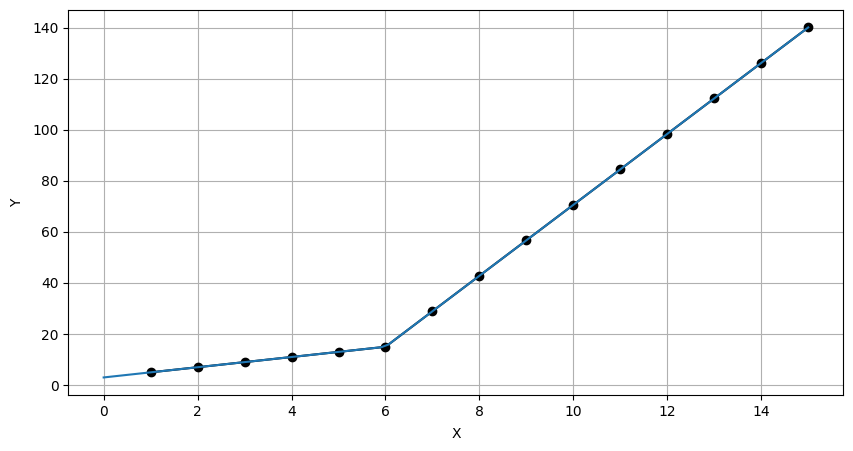

In [32]:
xd = np.linspace(0, 15, 100)
yp = piecewise_linear(xd, *p)

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(x, y, marker="o", color="k")
ax.plot(xd, yp)
ax.set_ylabel('Y', labelpad = 6)
ax.set_xlabel('X', labelpad = 6)
ax.grid(2)

Entretanto o nosso querido statsmodels automaticamente ja fita uma regressão não linear dado apenas uma variável, nesse caso estou utilizando a Tendência como $x$ e o Tempo como $y$.

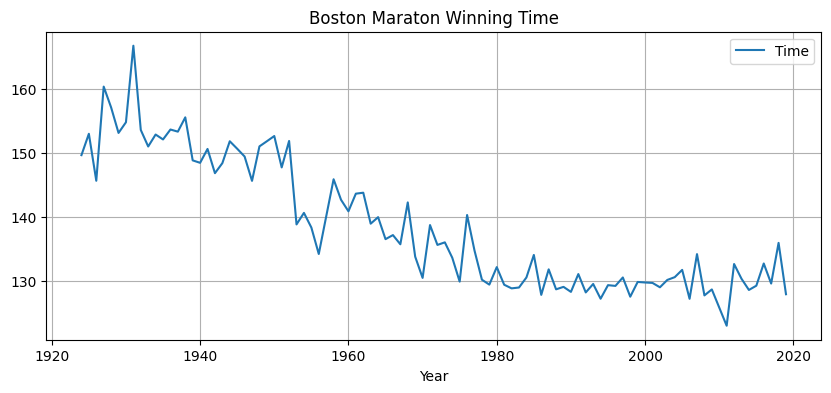

In [3]:
df = pd.read_csv('../data/boston_marathon.csv', index_col=[0])

df = df[(df['Year'] >= 1924) & (df['Event'] == "Men's open division")].reset_index(drop=True)

df['Time'] = df['Time'] / 60

df[['Year', 'Time']].plot(
    x='Year', 
    y='Time',
    figsize=(10,4),
    grid=2,
    title='Boston Maraton Winning Time'
);

In [4]:
stl = STL(df['Time'], period=10).fit()

df['Trend'] = stl.trend

In [5]:
df.head()

,Event,Year,Champion,Country,Time,Trend
0,Men's open division,1924,Clarence H. DeMar,United States,149.666667,154.275215
1,Men's open division,1925,Charles L. (Chuck) Mellor,United States,153.000000,154.327248
2,Men's open division,1926,John C. Miles,Canada,145.666667,154.357280
3,Men's open division,1927,Clarence H. DeMar,United States,160.366667,154.364041
4,Men's open division,1928,Clarence H. DeMar,United States,157.116667,154.348560


In [36]:
est = sm.OLS(
    df['Time'],
    df['Trend']
).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Time   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.714e+05
Date:                Sun, 17 Dec 2023   Prob (F-statistic):                   1.70e-156
Time:                        09:46:20   Log-Likelihood:                         -250.02
No. Observations:                  96   AIC:                                      502.0
Df Residuals:                      95   BIC:                                      504.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Trend          1.0001      0.002    413.958      0.000       0.995       1.005
==============================================================================
Omnibus:                       10.126   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               15.412
Skew:                           0.440   Prob(JB):                     0.000450
Kurtosis:                       4.754   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
df['Yhat'] = est.predict(df['Trend'])

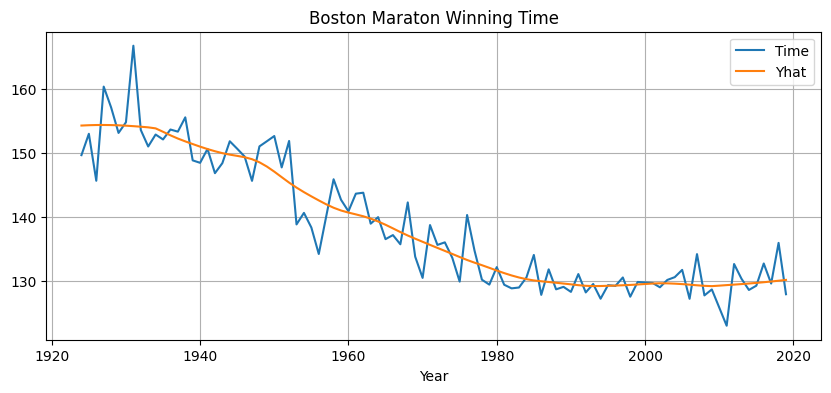

In [38]:
ax = df[['Year', 'Time']].plot(
    x='Year', 
    y='Time',
    figsize=(10,4),
    grid=2,
    title='Boston Maraton Winning Time'
);
df[['Year', 'Yhat']].plot(
    x='Year', 
    y='Yhat',
    figsize=(10,4),
    grid=2,
    ax = ax,
    title='Boston Maraton Winning Time'
);

In [7]:
# Definição da função de piercewise
def piecewise_linear(
    x,
    x0,
    y0,
    k1,
    k2
):
    return np.piecewise(x, [x < x0], [lambda x: k1 * x + y0 - k1 * x0, lambda x: k2 * x + y0 - k2 * x0])

In [8]:
x = df["Trend"].to_numpy()
y = df["Time"].to_numpy()

p, e = optimize.curve_fit(piecewise_linear, x, y)
yp = piecewise_linear(x, *p)

df["Yhat"] = yp

/home/grc/arep/time_series/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


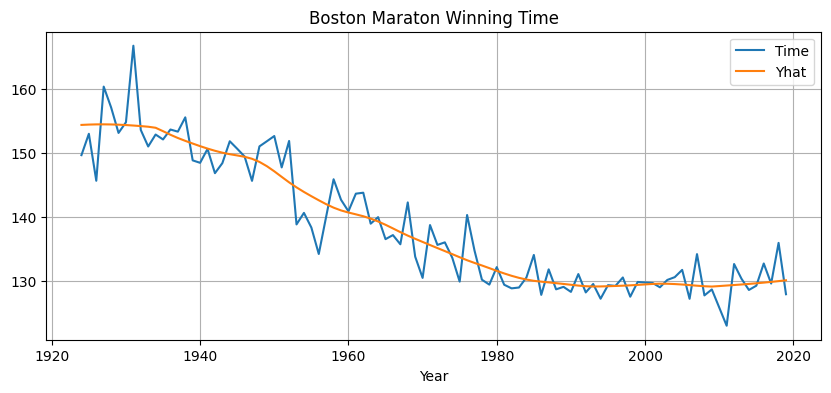

In [12]:
ax = df[['Year', 'Time']].plot(
    x='Year', 
    y='Time',
    figsize=(10,4),
);
df[['Year', 'Yhat']].plot(
    x='Year', 
    y='Yhat',
    grid=2,
    ax=ax,
    title='Boston Maraton Winning Time'
);

### 6.0. Previsão com Regressão

Existem duas formas para fazer a previsão do futuro com a regressão linear, a primeira é levando em conta a previsão das variáveis independentes, ou seja, se você quer prever o futuro com regressão você precisa prever todas as variáveis utilizadas no treinamento do modelo e dependendo da variável que foi utilizada pode ser mais difícil prever ela do que a variável dependente.
Já a segunda alternativa é prever um senário, este é apenas um indicativo com um intervalo de confiança para a onde que a variável dependente esta tendendo, seja uma tendência crescente ou decrescente.

E para calcular os intervalos de confiança é um pouco mais complexo, podemos utilizar as técnicas usadas anteriormente (bootstrap, ZScore, etc), entretanto existe uma fórmula de bolso para calcular o intervalo de confiança para uma regressão linear simples com apenas uma variável dependente e uma independente e assumindo que os resíduos são normalmente distribuídos é claro com a seguinte fórmula:

$\hat{y} \pm 1.96 \hat{\sigma}_e\sqrt{1+\frac{1}{T}+\frac{(x-\bar{x})^2}{(T-1)s_x^2}}$

Entretanto podemos utilzar outros approaches para esta mesma previsão dos intervalos (assumindo que você quer prever o futuro e consegue gerar as variaveis independentes para o futuro).

Existem artigos no médium que lhe mostra fórmulas também.
Assim temos as previsões do futuro e também o intervalo gerado utilizando regressão.

In [10]:
df = pd.read_csv("../data/aus_production.csv", index_col=[0])

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = df[df["Quarter"] >= "1992-01-01"]

df = df[["Quarter", "Beer"]].reset_index(drop=True)

df = df.set_index("Quarter").resample("Q-JAN").sum().reset_index()

In [18]:
df

,Quarter,Beer
0,1992-01-31,443
1,1992-04-30,410
2,1992-07-31,420
3,1992-10-31,532
4,1993-01-31,433
...,...,...
69,2009-04-30,398
70,2009-07-31,419
71,2009-10-31,488
72,2010-01-31,414


No livro é usado a Tendência e a Sazonalidade para treinar o modelo de regressão linear.

In [19]:
stl = STL(
    df.set_index("Quarter")["Beer"]
).fit()

df["Trend"] = stl.trend.values
df["Seasonal"] = stl.seasonal.values

In [20]:
df.head()

,Quarter,Beer,Trend,Seasonal
0,1992-01-31,443,450.526463,-6.997389
1,1992-04-30,410,450.336132,-39.191854
2,1992-07-31,420,450.032808,-30.782336
3,1992-10-31,532,449.616710,78.219029
4,1993-01-31,433,449.037084,-8.592110


#### 5.1. MLForecast

##### 5.1.1. Baseline MLForecast

O legal do MLForecast é que podemos utilizar outros modelos do SKlearn que suportam regressão como KNN, SVM, RF, e outros em pacotes externos como LGBM e XGBOOST...

In [21]:
dfm = df.copy()

dfm.columns = ["ds", "y", "trend", "seasonal"]

dfm["unique_id"] = "a"
dfm["static"] = 1

print(dfm.shape)
dfm.head()

(74, 6)


,ds,y,trend,seasonal,unique_id,static
0,1992-01-31,443,450.526463,-6.997389,a,1
1,1992-04-30,410,450.336132,-39.191854,a,1
2,1992-07-31,420,450.032808,-30.782336,a,1
3,1992-10-31,532,449.616710,78.219029,a,1
4,1993-01-31,433,449.037084,-8.592110,a,1


Podemos usar o MLForecast também para gerar previsões e o intervalo de confiânça do modelo.

In [ ]:
mlf = MLForecast(
    freq="Q-JAN",
    models=[LinearRegression()],
    date_features=["quarter"]
)

mlf.fit(
    dfm,
    prediction_intervals=PredictionIntervals(
        n_windows=2,
        h=8
    )
)

forecast = mlf.predict(h=8, level=[95])

In [60]:
forecast

,unique_id,ds,LinearRegression,LinearRegression-lo-95,LinearRegression-hi-95
0,a,2010-07-31,379.082055,355.619127,402.544983
1,a,2010-10-31,378.924330,276.738817,481.109843
2,a,2011-01-31,379.397506,346.674518,412.120493
3,a,2011-04-30,379.239780,367.019025,391.460535
4,a,2011-07-31,379.082055,348.119127,410.044983
5,a,2011-10-31,378.924330,278.088817,479.759843
6,a,2012-01-31,379.397506,351.354747,407.440265
7,a,2012-04-30,379.239780,368.155124,390.324437


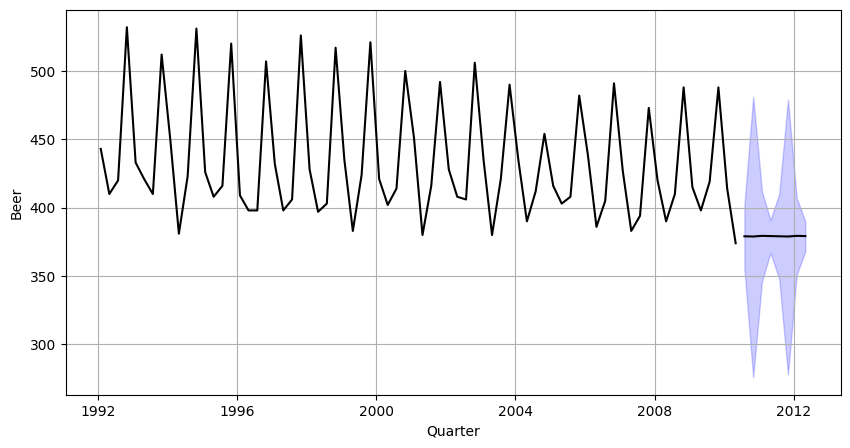

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Quarter", y="Beer", ax=ax, color="k")
sns.lineplot(forecast, x="ds", y="LinearRegression", ax=ax, color="k")

ax.fill_between(
    x=forecast["ds"],
    y1=forecast["LinearRegression-lo-95"].astype(int),
    y2=forecast["LinearRegression-hi-95"].astype(int),
    color="b",
    label="90",
    alpha=0.2
)

ax.grid(2);

##### 5.1.2. Dynamic MLForecast

Para incluir novas variáveis independentes no modelo, essas variáveis são chamadas de variáveis dinamicas no MLForecast.
Ah, precisa de uma variável dummy estatisca caso vocẽ USE O MAIS BASELINE POSSÍVEL DO MLForecast.

Irei incluir a tendencia, para ela irei fazer um simples naive pois os dados seguem reto nas ultimas observações, entretanto, para a sazonalidade irei criar outra feature que é o index do quarter apenas para termos duas.

In [116]:
dfm = dfm[["unique_id", "ds", "y", "trend", "static"]]
dfm["q"] = dfm["ds"].dt.quarter

dfm.head()

,unique_id,ds,y,trend,static,q
0,a,1992-01-31,443,450.526463,1,1
1,a,1992-04-30,410,450.336132,1,2
2,a,1992-07-31,420,450.032808,1,3
3,a,1992-10-31,532,449.616710,1,4
4,a,1993-01-31,433,449.037084,1,1


In [117]:
trend = dfm.loc[dfm.ds == dfm.ds.max(), ["trend"]].values[0][0]

In [118]:
forecast = forecast[["unique_id", "ds"]].copy()

forecast["trend"] = trend
forecast["q"] = forecast["ds"].dt.quarter

forecast

,unique_id,ds,trend,q
0,a,2010-07-31,420.162049,3
1,a,2010-10-31,420.162049,4
2,a,2011-01-31,420.162049,1
3,a,2011-04-30,420.162049,2
4,a,2011-07-31,420.162049,3
5,a,2011-10-31,420.162049,4
6,a,2012-01-31,420.162049,1
7,a,2012-04-30,420.162049,2


In [119]:
dynamic_features = ["trend", "q"]
static_features = ["static"]

In [120]:
mlf = MLForecast(
    freq="Q-JAN",
    models=[LinearRegression()],
    date_features=["quarter"]
)

mlf.fit(
    dfm,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    static_features=static_features,
    prediction_intervals=PredictionIntervals(
        n_windows=2,
        h=8
    )
)

MLForecast(models=[LinearRegression], freq=<QuarterEnd: startingMonth=1>, lag_features=[], date_features=['quarter'], num_threads=1)

Para colocar as variáveis independentes embutimos no argumento "dynamic_dfs" a tabela do futor.

In [ ]:
forecast_new = mlf.predict(
    h=8,
    level=[95],
    dynamic_dfs=[forecast]
)

In [128]:
# Sem o intervalo
mlf.predict(
    h=8,
    #level=[95],
    dynamic_dfs=[forecast]
)

,unique_id,ds,LinearRegression
0,a,2010-07-31,431.120776
1,a,2010-10-31,454.354038
2,a,2011-01-31,384.654254
3,a,2011-04-30,407.887515
4,a,2011-07-31,431.120776
5,a,2011-10-31,454.354038
6,a,2012-01-31,384.654254
7,a,2012-04-30,407.887515


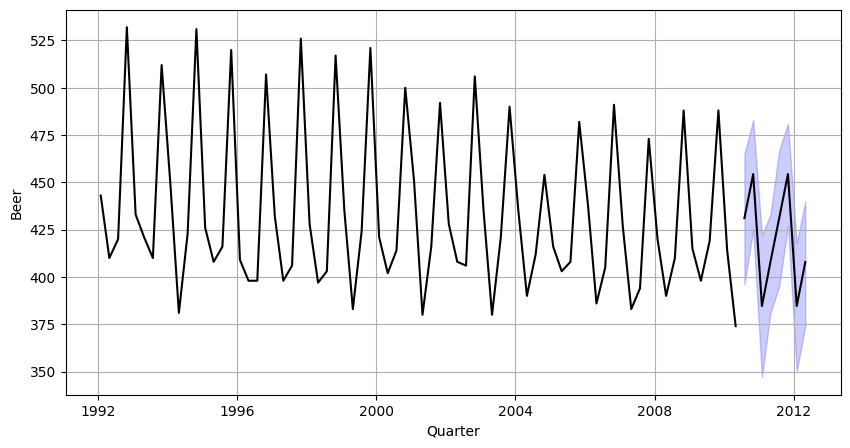

In [124]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Quarter", y="Beer", ax=ax, color="k")
sns.lineplot(forecast_new, x="ds", y="LinearRegression", ax=ax, color="k")

ax.fill_between(
    x=forecast_new["ds"],
    y1=forecast_new["LinearRegression-lo-95"].astype(int),
    y2=forecast_new["LinearRegression-hi-95"].astype(int),
    color="b",
    label="90",
    alpha=0.2
)

ax.grid(2);

##### 5.1.4. MLForecast Intervalos de Confiança

Diferente da abordagem anterior, o MLForecast utiliza o Cross Validation para obter o intervalo de confiança.

O método _cs_df retorna o cross validation utilizado no MLForecast, como especifiquemos um h = 2 e uma janela de 8 vamos ter 16 linhas no total.

O H significa o horizonte de previsão, nesse caso é 2, ou seja, o corte vai ser sempre de 2 em 2 anos levando em conta 8 intervalos.

Creates `n_windows` splits where each window has `h` test periods, trains the models, computes the predictions and merges the actuals.

In [222]:
mlf._cs_df

,unique_id,ds,cutoff,LinearRegression
0,a,2006-07-31,2006-04-30,34.983837
1,a,2006-10-31,2006-04-30,29.374102
2,a,2007-01-31,2006-04-30,38.657927
3,a,2007-04-30,2006-04-30,26.496103
4,a,2007-07-31,2006-04-30,37.172063
5,a,2007-10-31,2006-04-30,18.158110
6,a,2008-01-31,2006-04-30,34.444931
7,a,2008-04-30,2006-04-30,21.696100
0,a,2008-07-31,2008-04-30,27.458473
1,a,2008-10-31,2008-04-30,25.040823


Primeiro vamos entender mais a fundo como que é feito esse cross validation.

Em resumo é um código dinâmico que gera n splits contendo os intervalos desejados, porém, de trâs para frente (backtest split).

Irei montar manualmente os dois splits anteriormente criados.

In [131]:
n_windows = 2
h = 8

In [146]:
dfsplit = dfm.tail(n_windows * h)

dfsplit

,unique_id,ds,y,trend,static,q
58,a,2006-07-31,405,428.357200,1,3
59,a,2006-10-31,491,426.365437,1,4
60,a,2007-01-31,427,424.207790,1,1
61,a,2007-04-30,383,421.741115,1,2
62,a,2007-07-31,394,419.782339,1,3
63,a,2007-10-31,473,419.763822,1,4
64,a,2008-01-31,420,421.495718,1,1
65,a,2008-04-30,390,423.881964,1,2
66,a,2008-07-31,410,425.899734,1,3
67,a,2008-10-31,488,427.662868,1,4


In [215]:
split_1 = dfsplit.index[0]
split_2 = dfsplit.iloc[: len(dfsplit) // 2, :].index[-1]

df_train_kfold_1 = dfm.iloc[: split_1 + 1, :]
df_train_kfold_2 = dfm.iloc[: split_2 + 1, :]

df_test_kfold_1 = dfm.iloc[split_1:, :].reset_index(drop=2)
df_test_kfold_2 = dfm.iloc[split_2 + 1:, :].reset_index(drop=2)

df_test_kfold_1 = df_test_kfold_1[df_test_kfold_1.ds < df_test_kfold_2.ds.min()]

In [216]:
lr = LinearRegression()
lr = lr.fit(
    X=df_train_kfold_1[["trend", "q"]],
    y=df_train_kfold_1["y"]
)

df_test_kfold_1["yhat"] = lr.predict(df_test_kfold_1[["trend", "q"]])
df_test_kfold_1["e"] = np.abs(df_test_kfold_1["y"] - df_test_kfold_1["yhat"])

lr = LinearRegression()
lr = lr.fit(
    X=df_train_kfold_2[["trend", "q"]],
    y=df_train_kfold_2["y"]
)

df_test_kfold_2["yhat"] = lr.predict(df_test_kfold_2[["trend", "q"]])
df_test_kfold_2["e"] = np.abs(df_test_kfold_2["y"] - df_test_kfold_2["yhat"])

dfe = pd.concat([df_test_kfold_1, df_test_kfold_2], axis=0)

Após os dois fits, geremos o CV e os erros, lembrando que tem que ser absoluto ou a raiz quadrada dos erros ao quadrado (que vai dar na mesma) para não cancelarmos os erros.

In [221]:
dfe

,unique_id,ds,y,trend,static,q,yhat,e
0,a,2006-07-31,405,428.357200,1,3,438.432437,33.432437
1,a,2006-10-31,491,426.365437,1,4,459.643296,31.356704
2,a,2007-01-31,427,424.207790,1,1,386.838125,40.161875
3,a,2007-04-30,383,421.741115,1,2,407.513364,24.513364
4,a,2007-07-31,394,419.782339,1,3,428.761427,34.761427
5,a,2007-10-31,473,419.763822,1,4,452.197778,20.802222
6,a,2008-01-31,420,421.495718,1,1,383.779361,36.220639
7,a,2008-04-30,390,423.881964,1,2,409.927883,19.927883
0,a,2008-07-31,410,425.899734,1,3,437.204367,27.204367
1,a,2008-10-31,488,427.662868,1,4,462.081025,25.918975


Agora, precisamos das previsões para o futuro também, pois o intervalo de confiança vai ser desenhado para o futuro. Irei retreinar a regressão linear agora com todos os dados e usar o mesmo dataset do futuro a fim de utilizar ele para a geração dos intervalos.

In [227]:
lr = LinearRegression()
lr = lr.fit(
    X=dfm[["trend", "q"]],
    y=dfm["y"]
)

In [228]:
forecast = forecast[["unique_id", "ds"]].copy()

forecast["trend"] = trend
forecast["q"] = forecast["ds"].dt.quarter

forecast["yhat"] = lr.predict(forecast[["trend", "q"]])

,unique_id,ds,trend,q
0,a,2010-07-31,420.162049,3
1,a,2010-10-31,420.162049,4
2,a,2011-01-31,420.162049,1
3,a,2011-04-30,420.162049,2
4,a,2011-07-31,420.162049,3
5,a,2011-10-31,420.162049,4
6,a,2012-01-31,420.162049,1
7,a,2012-04-30,420.162049,2


Os valores ficaram praticamente iguais a previsão feita pelo pacote, agora vem a parte de calcular os intervalos de confiança! 

In [231]:
forecast

,unique_id,ds,trend,q,yhat
0,a,2010-07-31,420.162049,3,431.120776
1,a,2010-10-31,420.162049,4,454.354038
2,a,2011-01-31,420.162049,1,384.654254
3,a,2011-04-30,420.162049,2,407.887515
4,a,2011-07-31,420.162049,3,431.120776
5,a,2011-10-31,420.162049,4,454.354038
6,a,2012-01-31,420.162049,1,384.654254
7,a,2012-04-30,420.162049,2,407.887515


In [224]:
forecast_new

,unique_id,ds,LinearRegression,LinearRegression-lo-95,LinearRegression-hi-95
0,a,2010-07-31,431.120776,396.701342,465.540211
1,a,2010-10-31,454.354038,425.304932,483.403143
2,a,2011-01-31,384.654254,347.249288,422.059220
3,a,2011-04-30,407.887515,381.950484,433.824547
4,a,2011-07-31,431.120776,395.232629,467.008924
5,a,2011-10-31,454.354038,427.571911,481.136164
6,a,2012-01-31,384.654254,350.765885,418.542624
7,a,2012-04-30,407.887515,374.927405,440.847625


Primeiro vou criar os níveis de confiança, os alphas (1 - niveis de confiança) e dividir cada um deles por 2 (teste bicaldal) e obter as duas extremidades, similarmente igual o cálculo dos intervalos de confiânça utilizando o ZScore.

![image](https://upload.wikimedia.org/wikipedia/commons/0/01/ConfIntervNormalP.png)

In [232]:
levels = [.80]
alphas = [1 - k for k in levels]

# Divisão por 2 dados as duas caldas
lower = [a / 2 for a in alphas]
upper = [1 - a / 2 for a in alphas]

q = lower + upper

print(q)

[0.09999999999999998, 0.9]


Agora, irei pegar as previsões e os erros até o horizonte de previsões que é o comprimento das previsões.

Eu acredito que o idela seria pegar uma média dos k cross validations mas irei seguir como esta no MLForecast.

In [239]:
y = forecast["yhat"].values
e = dfe["e"].values[: len(forecast)]

pr = np.vstack([y - e, y + e])

Esses obtidos com o vstack são, digamos assim, os valores previstos pelo modelo, com a inclusão da variação observada do primeiro kfold desenvolvido, mas poderia ser o último também, por isso é o backtest.

In [246]:
pr

array([[397.68833915, 422.99733348, 344.49237926, 383.37415126,
        396.35934926, 433.55181589, 348.43361536, 387.95963239],
       [464.55321381, 485.71074168, 424.81612931, 432.4008795 ,
        465.88220371, 475.15625927, 420.87489321, 427.81539837]])

Agora utilizando essa média de previsão $\hat{y_t}$ e a variação dos kfold ou $e_t$, irei obter os quantiles dado o intervalo de confiânça estipulado anteriormente.

In [248]:
quantiles = np.quantile(pr, q, axis=0)

quantiles

array([[404.37482662, 429.2686743 , 352.52475426, 388.27682409,
        403.3116347 , 437.71226023, 355.67774314, 391.94520899],
       [457.86672635, 479.43940086, 416.78375431, 427.49820668,
        458.92991826, 470.99581493, 413.63076542, 423.82982177]])

In [251]:
quantiles = pd.DataFrame(quantiles).T
quantiles.columns = ["lower", "upper"]

In [255]:
forecast = pd.concat([forecast, quantiles], axis=1)

In [256]:
forecast

,unique_id,ds,trend,q,yhat,lower,upper
0,a,2010-07-31,420.162049,3,431.120776,404.374827,457.866726
1,a,2010-10-31,420.162049,4,454.354038,429.268674,479.439401
2,a,2011-01-31,420.162049,1,384.654254,352.524754,416.783754
3,a,2011-04-30,420.162049,2,407.887515,388.276824,427.498207
4,a,2011-07-31,420.162049,3,431.120776,403.311635,458.929918
5,a,2011-10-31,420.162049,4,454.354038,437.712260,470.995815
6,a,2012-01-31,420.162049,1,384.654254,355.677743,413.630765
7,a,2012-04-30,420.162049,2,407.887515,391.945209,423.829822


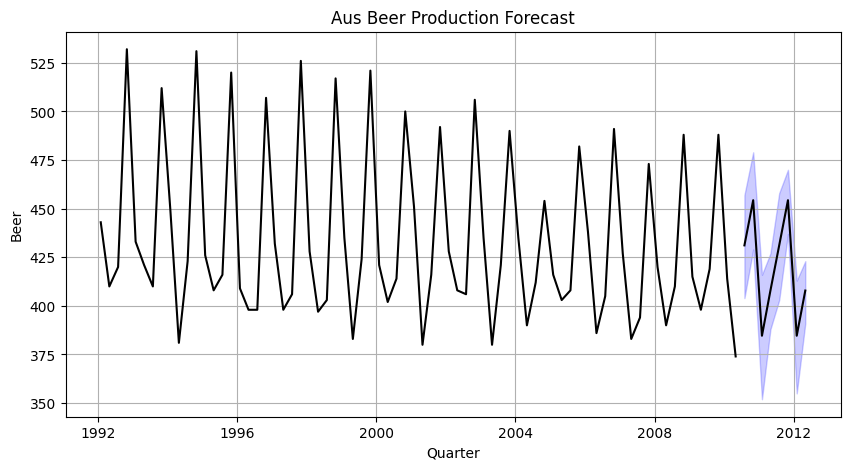

In [259]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Quarter", y="Beer", ax=ax, color="k")
sns.lineplot(forecast, x="ds", y="yhat", ax=ax, color="k")

ax.fill_between(
    x=forecast["ds"],
    y1=forecast["lower"].astype(int),
    y2=forecast["upper"].astype(int),
    color="b",
    label="90",
    alpha=0.2,
)

ax.set_title("Aus Beer Production Forecast")
ax.grid(2);

#### 5.2. OLS Linear Regression

Podemos fazer todo o mesmo calculo e ficar modificando e brincando agora para a versão do Stasmodels também!!

In [267]:
test = dfm.tail(4 * 2).reset_index()
train = dfm[dfm.ds < test.ds.min()]

In [268]:
ols = sm.OLS(
    train["y"],
    train[["trend", "q"]]
).fit()

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              5233.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):                    1.21e-71
Time:                        19:00:26   Log-Likelihood:                         -326.47
No. Observations:                  66   AIC:                                      656.9
Df Residuals:                      64   BIC:                                      661.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.8678      0.024     36.659      0.000       0.820       0.915
q             23.0105      3.801      6.054      0.000      15.417      30.604
==============================================================================
Omnibus:                      164.836   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.161
Skew:                           0.081   Prob(JB):                       0.0279
Kurtosis:                       1.394   Cond. No.                         389.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
test["yhat"] = ols.predict(test[["trend", "q"]])
test["e"] = np.abs(test["y"] - test["yhat"])

In [282]:
levels = [.80]
alphas = [1 - k for k in levels]

lower = [a / 2 for a in alphas]
upper = [1 - a / 2 for a in alphas]

q = lower + upper

print(q)

[0.09999999999999998, 0.9]


In [288]:
y = test["yhat"].values
e = test["e"].values

pr = np.vstack([y - e, y + e])

quantiles = np.quantile(pr, q, axis=0)
quantiles = pd.DataFrame(quantiles).T
quantiles.columns = ["lower", "upper"]

test = pd.concat([test, quantiles], axis=1)

In [289]:
test

,index,unique_id,ds,y,trend,static,q,yhat,e,lower,upper
0,66,a,2008-07-31,410,425.899734,1,3,438.611619,28.611619,415.722324,461.500914
1,67,a,2008-10-31,488,427.662868,1,4,463.152109,24.847891,443.273796,483.030422
2,68,a,2009-01-31,415,428.787415,1,1,395.096430,19.903570,379.173574,411.019286
3,69,a,2009-04-30,398,429.083961,1,2,418.364267,20.364267,402.072853,434.655681
4,70,a,2009-07-31,419,427.451575,1,3,439.958249,20.958249,423.191650,456.724849
5,71,a,2009-10-31,488,425.287937,1,4,461.091230,26.908770,439.564215,482.618246
6,72,a,2010-01-31,414,422.878334,1,1,389.968747,24.031253,370.743745,409.193749
7,73,a,2010-04-30,374,420.162049,1,2,410.622161,36.622161,381.324432,439.919890


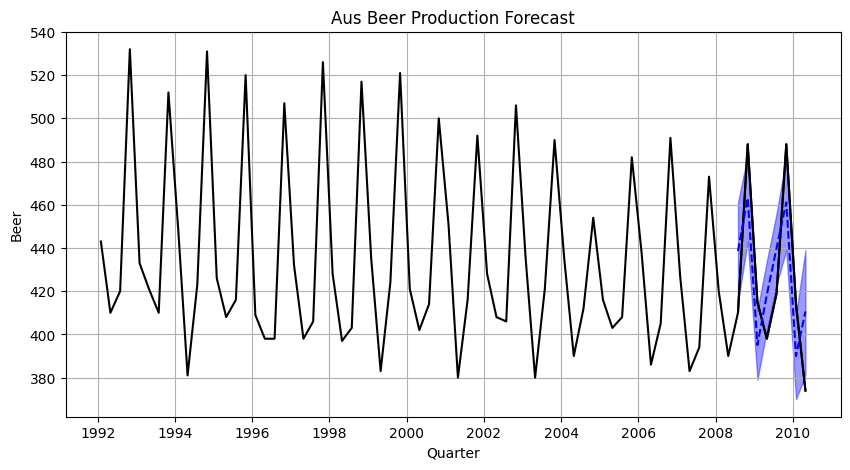

In [291]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Quarter", y="Beer", ax=ax, color="k")
sns.lineplot(test, x="ds", y="y", ax=ax, color="k")
sns.lineplot(test, x="ds", y="yhat", ax=ax, color="b", linestyle="--")

ax.fill_between(
    x=test["ds"],
    y1=test["lower"].astype(int),
    y2=test["upper"].astype(int),
    color="b",
    label="90",
    alpha=0.4,
)

ax.set_title("Aus Beer Production Forecast")
ax.grid(2);